In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as pdr
import pandas_datareader
import copy
import matplotlib.pyplot as plt
import os
import tensorflow_ranking as tfr
import tensorflow as tf
import ast

PATH = os.getcwd()

### Load the rankings:

In [83]:
rankings = pd.read_csv(os.path.join(PATH, 'ranking_results7.csv')) #Note that rankings['ranking'] is read literally as a str
rankings['ranking']= rankings['ranking'].apply(lambda x: ast.literal_eval(x)) #ast.literal_eval(x) evaluate the string containing a Python literal
rankings['date'] = pd.to_datetime(rankings['date']).dt.date
rankings

,date,ranking
0,2018-12-09,"[PCG, TGT, CAR, GS, AAPL, GE, AIG, KKR, COO, M..."
1,2018-12-16,"[AAPL, FDX, RF, C, GIS, GS, GE, WFC, NTRS, CRM..."
2,2018-12-23,"[FDX, PM, CRM, CNC, AMZN, CI, GD, MGM, CVS, C,..."
3,2018-12-30,"[FDX, C, UPS, DAL, KKR, JPM, WFC, NFLX, AMZN, ..."
4,2019-01-06,"[AAPL, DAL, UNH, JNJ, C, ABC, TSLA, AXP, MO, X..."
...,...,...
151,2021-10-31,"[CAR, TSLA, PCG, BX, GM, DFS, KKR, AAL, IBM, C..."
152,2021-11-07,"[CAR, TSLA, DAL, UAL, LUV, DD, AMD, QCOM, TGT,..."
153,2021-11-14,"[CAR, TSLA, QCOM, F, AAL, IBM, PFE, LUV, AMD, ..."
154,2021-11-21,"[CAR, QCOM, TSLA, ET, V, AMD, GM, DD, DFS, MA,..."


In [78]:
'''
Chose any universe of stocks and stick to this group of stock as the source for your portfolio for the entire
duration of backtesting. In our case, that's the 108 companies we have data on.

Build fixed individual position portfolio by picking m number of stocks based on weekly ranking outputted by the model.

Rebalance the portfolio every week by removing worse x stocks and replacing them with top x stocks from the universe 
of stocks

Backtest the strategy and compare the KPIs with that of simple buy and hold strategy of corresponding index (S&P500).

'''

#Import the KPIs functions that we'll use

def CAGR(DF): #Notice it's been changed to weekly (thus, the 52). Besides, a column in DF is needed with the mon_ret
    "function to calculate the Compound Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["week_ret"]).cumprod()
    n = len(df)/52
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):  #Notice it's been changed to monthly (thus, the sqrt(52))
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["week_ret"].std() * np.sqrt(52)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["week_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [5]:
# Download historical data (weekly) for our stock universe constituent stocks

start_date = (rankings.date.iloc[0]).strftime('%Y-%m-%d')
end_date = (rankings.date.iloc[-1]+dt.timedelta(days=7)).strftime('%Y-%m-%d') # +7 to get the last Mon-Sun data

#Stock Universe
concatenated_stocks = rankings.ranking.sum() #Concatenate all rankings of stocks in one big list
tickers = list(set(concatenated_stocks)) #Take only the unique stocks in that big list --> our stock universe

ohlc_week = {} # directory with ohlc value for each stock            
attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] # removing stocks whose data has been extracted from the ticker list
    for i in range(len(tickers)):
        try:
            panel_data = pandas_datareader.yahoo.daily.YahooDailyReader(tickers[i], interval='d', start=start_date, end=end_date).read()
            panel_data['W_Date'] = pd.to_datetime(panel_data.index)
            panel_data = panel_data.groupby(pd.Grouper(key='W_Date', freq='W-SUN', label= 'right', sort=True)).agg(lambda x: x[-1]).reset_index().sort_values('W_Date')
            panel_data = pd.DataFrame(panel_data.set_index('W_Date'))
            panel_data.index.names = ['Date'] #Rename index

            ohlc_week[tickers[i]] = panel_data
            ohlc_week[tickers[i]].dropna(inplace = True)
            drop.append(tickers[i])       
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1

tickers = ohlc_week.keys() # redefine tickers variable after removing any tickers with corrupted data

In [31]:
################################Backtesting####################################

# calculating weekly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_week) #deep copy to make sure any changes in the dictionary doesn't affect the original
return_df = pd.DataFrame()
for ticker in tickers:
    #print("calculating weekly return for ",ticker)
    ohlc_dict[ticker]["week_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["week_ret"]

# function to calculate portfolio return iteratively
def pflio(DF,RankDF,m,strategy):
    """Returns cumulative portfolio return
    DF = dataframe with weekly return info for all stocks
    m = number of stock in the portfolio
    strategy = Type of strategy to apply --> Long on the top stocks, or Short the last stocks 
    """
    df = DF.copy()
    rdf = RankDF.copy()
    weekly_ret = [0] #Init a list with the returns of every week (first on is always 0)
    for i in range(1,len(df)): #For every week 
        if strategy == 'long':
            portfolio = rdf.ranking[i][:m]
            weekly_ret.append(df[portfolio].iloc[i,:].mean()) #df[portfolio].iloc[i,:] is a series object with the tickers in portfolio as index and the ith weekly returns as their values. Then we average that
        if strategy == 'short':
            portfolio = rdf.ranking[i][-m:]
            weekly_ret.append(-df[portfolio].iloc[i,:].mean()) #df[portfolio].iloc[i,:] is a series object with the tickers in portfolio as index and the ith weekly returns as their values. Then we average that
        if strategy == 'long&short':
            l_size = round(m/2)
            s_size = (m-round(m/2)) 
            l_portfolio = rdf.ranking[i][:l_size]
            s_portfolio = rdf.ranking[i][-s_size:]
            weekly_ret.append((l_size*df[l_portfolio].iloc[i,:].mean() - s_size*df[s_portfolio].iloc[i,:].mean())/(l_size+s_size)) #df[portfolio].iloc[i,:] is a series object with the tickers in portfolio as index and the ith weekly returns as their values. Then we average that
    weekly_ret_df = pd.DataFrame(np.array(weekly_ret),columns=["week_ret"])
    return weekly_ret_df

C:\Users\ericb\AppData\Local\Temp\ipykernel_19668\796636658.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return_df[ticker] = ohlc_dict[ticker]["week_ret"]
C:\Users\ericb\AppData\Local\Temp\ipykernel_19668\796636658.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return_df[ticker] = ohlc_dict[ticker]["week_ret"]
C:\Users\ericb\AppData\Local\Temp\ipykernel_19668\796636658.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [84]:
#calculating overall long strategy's KPIs with portfolio size = 27 = 25% of 108
print("LTR long strategy with 27 size portfolio ----------------")
print("CAGR:",CAGR(pflio(return_df,rankings,27,'long')))
print("Sharpe Ratio:",sharpe(pflio(return_df,rankings,27,'long'),0.005))
print("max drawdown:",max_dd(pflio(return_df,rankings,27,'long'))) 
print('Cumulative return:', (1+pflio(return_df,rankings,27,'long')).cumprod().week_ret.iloc[-1])
print("---------------------------------------------------------")

#calculating overall long strategy's KPIs with portfolio size = 5
print("LTR long strategy with 5 size portfolio -----------------")
print("CAGR:",CAGR(pflio(return_df,rankings,5,'long')))
print("Sharpe Ratio:",sharpe(pflio(return_df,rankings,5,'long'),0.005))
print("max drawdown:",max_dd(pflio(return_df,rankings,5,'long'))) 
print('Cumulative return:', (1+pflio(return_df,rankings,5,'long')).cumprod().week_ret.iloc[-1])
print("---------------------------------------------------------")

#calculating KPIs for S&P500 buy and hold strategy over the same period
SYP = pdr.get_data_yahoo("^GSPC",start=start_date, end=end_date,interval='w')
SYP["week_ret"] = SYP["Adj Close"].pct_change()
print("S&P500 buy and hold -------------------------------------")
print("CAGR S&P500:",CAGR(SYP))
print("Sharpe Ratio S&P500:",sharpe(SYP,0.005))
print("max drawdown S&P500:",max_dd(SYP)) 
print('Cumulative return:', (1+SYP["week_ret"].reset_index(drop=True)).cumprod().iloc[-1])
print("---------------------------------------------------------")

LTR long strategy with 27 size portfolio ----------------
CAGR: 0.29415317651380746
Sharpe Ratio: 0.8486049410321668
max drawdown: 0.4321367649024766
Cumulative return: 2.167489727894353
---------------------------------------------------------
LTR long strategy with 5 size portfolio -----------------
CAGR: 0.4141230076483555
Sharpe Ratio: 0.7984037096094835
max drawdown: 0.5922768471045464
Cumulative return: 2.827883831187335
---------------------------------------------------------
S&P500 buy and hold -------------------------------------
CAGR S&P500: 0.20405656526735205
Sharpe Ratio S&P500: 0.9550486278387625
max drawdown S&P500: 0.3181032904337878
Cumulative return: 1.7455836693070357
---------------------------------------------------------


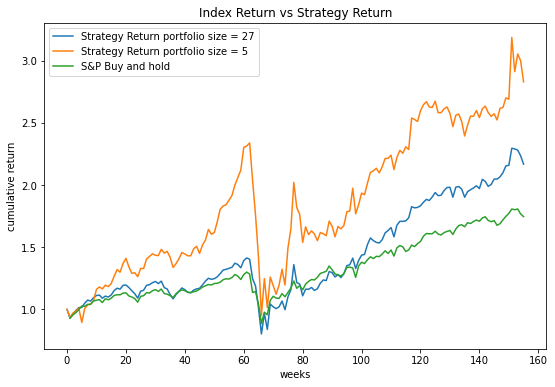

In [85]:
#visualization
fig, ax = plt.subplots(figsize = (9,6))
plt.plot((1+pflio(return_df,rankings,27,'long')).cumprod()[:])
plt.plot((1+pflio(return_df,rankings,5,'long')).cumprod()[:])
plt.plot((1+SYP["week_ret"].reset_index(drop=True)).cumprod()[:])
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("weeks")
ax.legend(["Strategy Return portfolio size = 27","Strategy Return portfolio size = 5","S&P Buy and hold"])